In [1]:
import pandas as pd
import numpy as np
import Bio
import BCBio
from BCBio import GFF
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pfam_clan = "/labs/mpsnyder/khoa/data/Pfam_Release37.2/Pfam-A.clans.tsv"
df_clan = pd.read_csv(pfam_clan, sep="\t", header=None)
df_clan.columns = ["pfam", "pclan", "acc_clan", "acc_fam", "desc"]

In [3]:
# fill missing values in the 'clan' column with pfam column
df_clan['pclan'] = df_clan['pclan'].fillna(df_clan['pfam'])

In [4]:
clan_fam_dict = dict(zip(df_clan['pfam'], df_clan['pclan']))

In [7]:
integrated_enzyme_names = ["integrase", "recombinase", "transposase", "integration", "recombination", "transposition"]
integrated_enzyme_names = [" phage "]

df_clan["DOI"] = df_clan["desc"].str.contains("|".join(integrated_enzyme_names), case=False)
df_clan[df_clan["DOI"]]

,pfam,pclan,acc_clan,acc_fam,desc,DOI
1922,PF02061,PF02061,NaN,Lambda_CIII,Lambda Phage CIII,True
3718,PF04020,PF04020,NaN,Phage_holin_4_2,"Mycobacterial 4 TMS phage holin, superfamily IV",True
4328,PF04688,PF04688,NaN,Holin_SPP1,SPP1 phage holin,True
6069,PF06591,PF06591,NaN,Phage_T4_Ndd,T4-like phage nuclear disruption protein (Ndd),True
6334,PF06891,CL0691,Tail_Terminator,P2_Phage_GpR,P2 phage tail completion protein R (GpR),True
6481,PF07066,CL0219,RNase_H,DUF3882,Lactococcus phage M3 protein,True
6848,PF07459,PF07459,NaN,CTX_RstB,CTX phage RstB protein,True
8540,PF09251,CL0268,Pec_lyase-like,PhageP22-tail,Salmonella phage P22 tail-spike,True
8798,PF09524,PF09524,NaN,Phg_2220_C,Conserved phage C-terminus (Phg_2220_C),True
8943,PF09681,CL0123,HTH,Phage_rep_org_N,N-terminal phage replisome organiser (Phage_re...,True


In [8]:
def generate_feature_vector(chunk, id_pclan_dict, feature_dict):
    for chunk in chunks:
        if chunk.type == "CDS":
            clans = id_pclan_dict.get(chunk.id, "unknown")
            for clan in clans:
                feature_dict[clan] += 1
        else:
            feature_dict[chunk.type] += 1
    return feature_dict

def get_feature_types(gff_file):
    # get all feature types from gff file
    feature_types = set()
    with open(gff_file) as infile:
        for record in GFF.parse(infile):
            for feature in record.features:
                feature_types.add(feature.type)
    return feature_types

def parse_gff_in_chunks(gff_file, chunk_size, stride):
    chunked_features = []

    with open(gff_file) as infile:
        for record in GFF.parse(infile):
            seq_len = max([int(feature.location.end) for feature in record.features], default=0)  # Get max feature position
            start_positions = list(range(0, seq_len, stride))  # Generate chunk start positions

            for start in start_positions:
                end = start + chunk_size
                chunk_features = [
                    feature for feature in record.features
                    if feature.location.start >= start and feature.location.start < end
                ]
                if chunk_features:
                    chunked_features.append(chunk_features)

    return chunked_features
    
def read_tsv_robust(file_path):
    with open(file_path, "r") as file:
        lines = [line.strip().split() for line in file if not line.startswith("#")]
    max_cols = max(len(row) for row in lines)
    padded_lines = [row + [None] * (max_cols - len(row)) for row in lines]
    df = pd.DataFrame(padded_lines)
    return df


In [15]:
gff_file = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/prokka_out/PROKKA_03122025.gff"
# gff_file = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/bakta_out/assembly.gff3"
chunk_size = 500000000
stride = 100000000
chunked_features = parse_gff_in_chunks(gff_file, chunk_size, stride)
print(f"Number of chunks: {len(chunked_features)}")

Number of chunks: 7


In [16]:
# parse features keep only type and id (feature.type, feature.id)
chunked_features_parsed = []
for chunk in chunked_features:
    chunk_parsed = []
    for feature in chunk:
        chunk_parsed.append({
            "type": feature.type,
            "id": feature.id,
            "product": feature.qualifiers.get("product", [""])[0],
            "start": feature.location.start,
            "end": feature.location.end,
            "length": len(feature),
        })
    chunked_features_parsed.append(chunk_parsed)
print(f"Number of chunks parsed: {len(chunked_features_parsed)}")
print(chunked_features_parsed[:1])


Number of chunks parsed: 7
[[{'type': 'CDS', 'id': 'DFNOFNBE_00001', 'product': 'hypothetical protein', 'start': ExactPosition(391), 'end': ExactPosition(577), 'length': 186}, {'type': 'CDS', 'id': 'DFNOFNBE_00002', 'product': 'hypothetical protein', 'start': ExactPosition(910), 'end': ExactPosition(1840), 'length': 930}, {'type': 'CDS', 'id': 'DFNOFNBE_00003', 'product': 'hypothetical protein', 'start': ExactPosition(2116), 'end': ExactPosition(3586), 'length': 1470}, {'type': 'CDS', 'id': 'DFNOFNBE_00004', 'product': 'hypothetical protein', 'start': ExactPosition(3483), 'end': ExactPosition(4206), 'length': 723}, {'type': 'CDS', 'id': 'DFNOFNBE_00005', 'product': 'Acetoin catabolism regulatory protein', 'start': ExactPosition(4382), 'end': ExactPosition(6203), 'length': 1821}, {'type': 'CDS', 'id': 'DFNOFNBE_00006', 'product': 'sn-glycerol-3-phosphate import ATP-binding protein UgpC', 'start': ExactPosition(6456), 'end': ExactPosition(7551), 'length': 1095}, {'type': 'CDS', 'id': 'DF

In [17]:
pfam_out = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/prokka_out/PROKKA_03122025.PFAM"
df_pfam = read_tsv_robust(pfam_out)
df_pfam = df_pfam.iloc[:, :5]
df_pfam.columns = ["name", "pfam_acc", "id", "space", "evalue"]
df_pfam["pfam"] = df_pfam["pfam_acc"].apply(lambda x: x.split(".")[0] if pd.notna(x) else x)
df_pfam["clan"] = df_pfam["pfam"].map(clan_fam_dict)
df_pfam["evalue"] = df_pfam["evalue"].astype(float)
df_pfam = df_pfam[df_pfam["evalue"] < 0.001]
id_pclan_dict = df_pfam.groupby("id").agg({"clan":list}).to_dict()['clan']
id_integrated_dict = df_clan.set_index("pclan")["DOI"].to_dict()
df_pfam["DOI"] = df_pfam["clan"].map(id_integrated_dict)
id_integrated_dict = df_pfam.groupby("id").agg({"DOI": "any"}).to_dict()['DOI']

In [18]:
window = int(len(chunked_features_parsed[0]) * 0.01)
df_product = pd.DataFrame(chunked_features_parsed[0])
df_product["pclan"] = df_product["id"].map(id_pclan_dict)
df_product["DOI"] = df_product["id"].map(id_integrated_dict)
df_product["protein_annotated"] = ~df_product["product"].str.contains("hypothetical protein") * 1.
df_product["clan_annotated"] = df_product["pclan"].apply(lambda x: 1. if isinstance(x, list) else 0.)
df_product["protein_annotated_mavg"] = df_product["protein_annotated"].rolling(window=window, center = True).mean()
df_product["clan_annotated_mavg"] = df_product["clan_annotated"].rolling(window=window, center = True).mean()

In [19]:
df_product

,type,id,product,start,end,length,pclan,DOI,protein_annotated,clan_annotated,protein_annotated_mavg,clan_annotated_mavg
0,CDS,DFNOFNBE_00001,hypothetical protein,391,577,186,NaN,NaN,0.0,0.0,NaN,NaN
1,CDS,DFNOFNBE_00002,hypothetical protein,910,1840,930,NaN,NaN,0.0,0.0,NaN,NaN
2,CDS,DFNOFNBE_00003,hypothetical protein,2116,3586,1470,NaN,NaN,0.0,0.0,NaN,NaN
3,CDS,DFNOFNBE_00004,hypothetical protein,3483,4206,723,NaN,NaN,0.0,0.0,NaN,NaN
4,CDS,DFNOFNBE_00005,Acetoin catabolism regulatory protein,4382,6203,1821,"[CL0023, CL0023, CL0123, CL0123, CL0023]",False,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5863,CDS,DFNOFNBE_05864,Peptidyl-prolyl cis-trans isomerase cyp18,5882634,5883138,504,[CL0475],False,1.0,1.0,NaN,NaN
5864,CDS,DFNOFNBE_05865,Glutamine--tRNA ligase,5883385,5885086,1701,"[CL0039, CL0733, CL0733]",False,1.0,1.0,NaN,NaN
5865,CDS,DFNOFNBE_05866,Cysteine--tRNA ligase,5885107,5886490,1383,"[CL0039, CL0258, CL0039, PF23493, CL0039, CL0039]",False,1.0,1.0,NaN,NaN
5866,CDS,DFNOFNBE_05867,putative protein YyaP,5886561,5887110,549,[CL0387],False,1.0,1.0,NaN,NaN


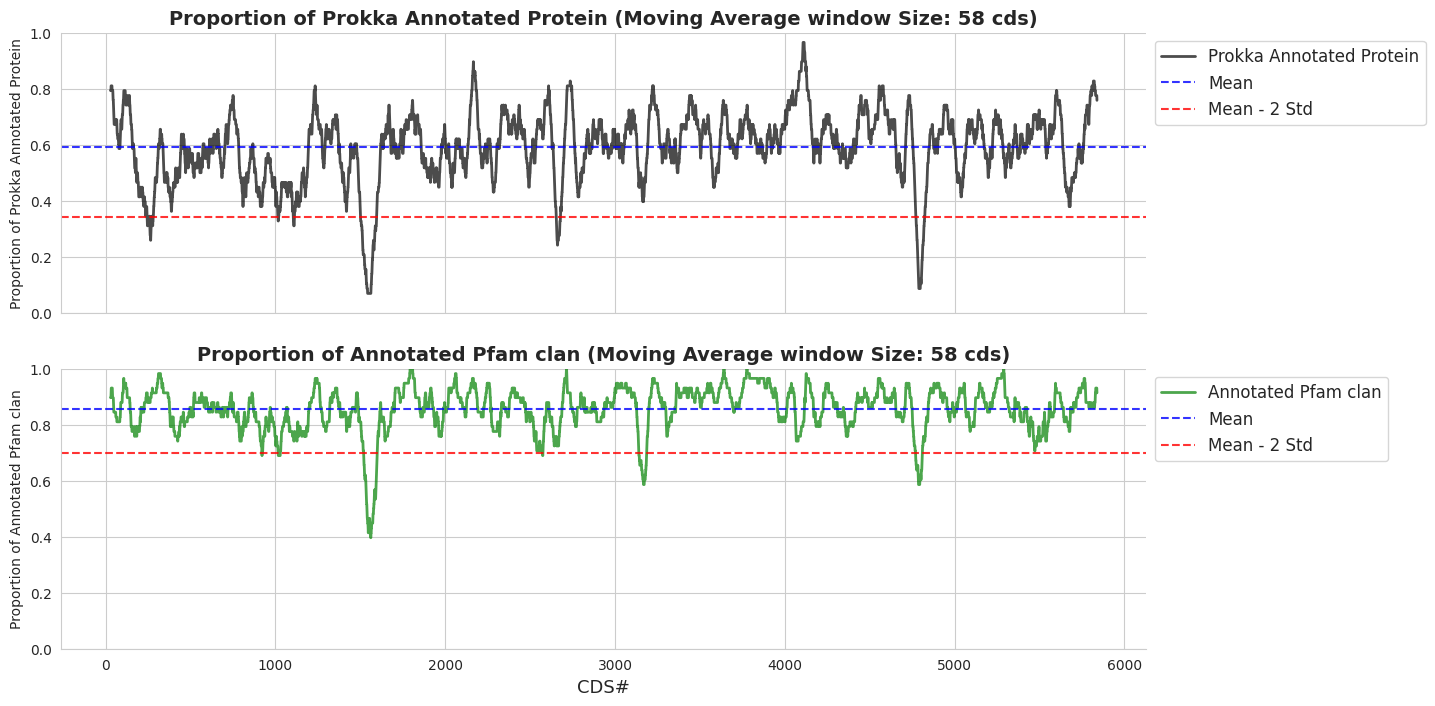

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Create figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Define colors
colors = ["black", "green"]  
highlight_colors = ["blue", "red"]
names = ["Prokka Annotated Protein", "Annotated Pfam clan"]
# Plot data with enhancements
for i, (col, color) in enumerate(zip(["protein_annotated_mavg", "clan_annotated_mavg"], colors)):
    mean, std = df_product[col].mean(), df_product[col].std()
    
    # Lineplot with transparency for smooth look
    sns.lineplot(data=df_product, x=df_product.index, y=col, ax=axes[i], color=color, linewidth=2, label=f"{names[i]}", alpha=0.7)
    # Highlight mean and ±2 standard deviation with dashed lines
    for offset, hcolor, label in zip([0, -2 * std], highlight_colors, ["Mean", "Mean - 2 Std"]):
        axes[i].axhline(mean + offset, color=hcolor, linestyle='--', linewidth=1.5, alpha=0.8, label=label)
    # Customize appearance
    axes[i].set_ylabel(f"Proportion of {names[i]}")
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f"Proportion of {names[i]} (Moving Average window Size: {window} cds)", fontsize=14, fontweight="bold")
    axes[i].legend(frameon=True, fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

    #plot vertical lines for DOI == True
    # for idx, row in df_product[df_product["DOI"] == 1].iterrows():
    #     axes[i].axvline(x=idx, color="red", linestyle="--", alpha=0.5)    

# Fine-tune layout
plt.xlabel("CDS#", fontsize=13)

# Show plot
plt.show()


In [275]:
path_genomad = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/genomad_out/assembly_annotate/assembly_genes.tsv"
df_genomad = pd.read_csv(path_genomad, sep="\t")
df_genomad["contig"] = df_genomad["gene"].apply(lambda x: x.split("_")[1])
df_genomad_contig1 = df_genomad[df_genomad["contig"] == "1"]

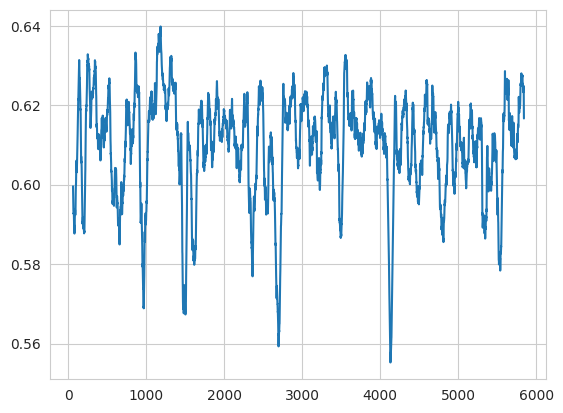

In [286]:
plt.plot(df_genomad_contig1.gc_content.rolling(window=60).mean())

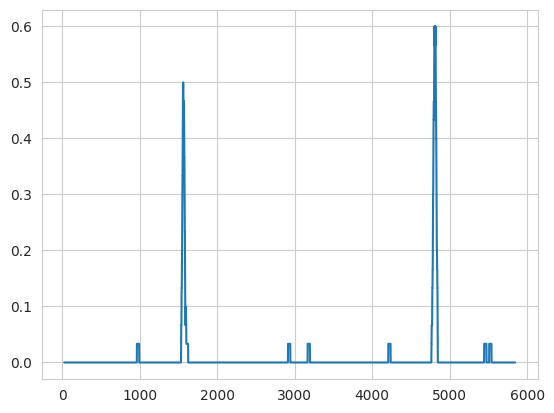

In [301]:
plt.plot(df_genomad_contig1.virus_hallmark.rolling(window=30).mean())

In [22]:
path_mmseqs = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/prokka_out/mmseqs_cluster/mmseqs_clusters_cluster.tsv"
path_prokka_annot = "/labs/mpsnyder/khoa/data/Pseudo_fluor_nanopore/prokka_out/PROKKA_03122025.tsv"
df_prokka = pd.read_csv(path_prokka_annot, sep="\t")
id_product_dict = dict(zip(df_prokka["locus_tag"], df_prokka["product"]))
df_cluster = pd.read_csv(path_mmseqs, sep="\t", header=None)
df_cluster.columns = ["id", "protein"]
df_cluster["product"] = df_cluster["id"].map(id_product_dict)


df_groups = df_cluster.groupby("id").agg({"protein": "count", "product": lambda x: np.unique(x)}).sort_values("protein", ascending=False)[:30]


In [23]:
df_groups[df_groups["protein"] > 1]

,protein,product
id,,
DFNOFNBE_00161,20,[IS30 family transposase ISPpu17]
DFNOFNBE_01473,8,[IS110 family transposase ISPpu10]
DFNOFNBE_05743,8,[Histidine transport ATP-binding protein HisP]
DFNOFNBE_06029,7,[Tn3 family transposase ISPa40]
DFNOFNBE_00176,6,[IS3 family transposase IS1240]
DFNOFNBE_04926,6,[hypothetical protein]
DFNOFNBE_00378,6,[IS3 family transposase ISBcen9]
DFNOFNBE_00377,6,[IS3 family transposase ISPa79]
DFNOFNBE_04569,5,[Transcriptional activator protein CzcR]


In [302]:
df_cluster[df_cluster["id"] == "DFNOFNBE_04926"]

,id,protein,product
3492,DFNOFNBE_04926,DFNOFNBE_04926,hypothetical protein
3493,DFNOFNBE_04926,DFNOFNBE_02198,hypothetical protein
3494,DFNOFNBE_04926,DFNOFNBE_04953,hypothetical protein
3495,DFNOFNBE_04926,DFNOFNBE_02148,hypothetical protein
3496,DFNOFNBE_04926,DFNOFNBE_05517,hypothetical protein
3497,DFNOFNBE_04926,DFNOFNBE_01792,hypothetical protein


In [81]:
unknown_set = set("unknown")
clan_set = set(df_clan.pclan)
feature_types = get_feature_types(gff_file)
# combine clan_set and feature_types
combined_set = clan_set.union(feature_types).union(unknown_set)
feature_dict = {}
for feature in combined_set:
    feature_dict[feature] = 0